In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN



## **Разделим данные на тренировочные и тестовые и сделаем конвеер для первичной обработки**

In [2]:
df_class = pd.read_excel("data.xlsx")
train_class, test_class = train_test_split(df_class, test_size=0.3, random_state=42)

#### **Класс для создания классификационной переменной**

In [ ]:
class CreateClasses(BaseEstimator, TransformerMixin):
    def __init__(self, SI_col='SI'):
        self.SI_col = SI_col
        
    def fit(self, X, y=None):
        # Запоминаем медианы для преобразования новых данных
        self.SI_col_median_ = X[self.SI_col].median()
        return self
    
    def transform(self, X):
        X = X.copy()
        X["SI_class"] = X[self.SI_col] > self.SI_col_median_
        return X

#### **Класс для рассчета Si**

In [4]:
class Calc_Si(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X["SI"] = X["CC50, mM"] / X["IC50, mM"]
        return X

#### **Класс для удаления выбросов**

In [5]:
class Outliers_data(BaseEstimator, TransformerMixin):

    def __init__(self, target_cols, threshold=1000):
        self.columns =  target_cols #["IC50, mM", "SI"]
        self.threshold = threshold

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.filters_ = (X[self.columns] <= self.threshold).all(axis=1)
        return X[self.filters_].copy()

#### **Класс для удаления нулевых признаков**

In [7]:
class DropZeroData(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop_ = None

    def fit(self, X, y=None):
        self.columns_to_drop_ = X.columns[X.sum() == 0].tolist()
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop_)

#### **Класс для создания новых признаков**

In [8]:
class FeatureAggregator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):      
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # Групповые суммы
        X_transformed['Hydrophilic_VSA'] = X[['SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3']].sum(axis=1)
        X_transformed['Moderate_VSA'] = X[['SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6']].sum(axis=1)
        X_transformed['Lipophilic_VSA'] = X[['SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA10']].sum(axis=1)
        X_transformed['frointier_VSA'] = X[['SlogP_VSA11', 'SlogP_VSA12']].sum(axis=1)
        
        # Разности
        X_transformed["DiffPartialCharge"] = X["MaxPartialCharge"] - X["MinPartialCharge"]
        X_transformed["DiffEStateIndex"] = X["MaxEStateIndex"] - X["MinEStateIndex"]
        
        return X_transformed

#### **Данные по матрице корреляции**

In [9]:
data_to_drop = ['fr_COO',
 'fr_COO2',
 'fr_Nhpyrrole',
 'fr_COO2',
 'fr_phenol_noOrthoHbond',
 'fr_phenol',
 'fr_phenol_noOrthoHbond',
 'fr_C_O_noCOO',
 'fr_Al_OH_noTert',
 'fr_nitro_arom_nonortho',
 'fr_ketone_Topliss',
 'fr_halogen',
 'fr_NH0','BCUT2D_MRHI', 'BCUT2D_LOGPLOW', 'BCUT2D_LOGPHI']

### **Класс для отбора признаков**

In [10]:
class MutualInfoFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, target_col='CC50, mM', threshold=0.1, random_state=42):
        self.target_col =target_col
        self.threshold = threshold
        self.random_state = random_state
        self.selected_features_ = None
        self.feature_importances_ = None
    
    def fit(self, X):
        y = X[self.target_col]
        X_mut = X.drop(columns = self.target_col) 
        # Вычисляем mutual information
        importances = mutual_info_regression(X_mut, y, random_state=self.random_state)
        
        # Сохраняем важность признаков
        self.feature_importances_ = pd.Series(importances, index=X_mut.columns)
        
        # Выбираем признаки, превышающие порог
        self.selected_features_ = self.feature_importances_[
            self.feature_importances_ >= self.threshold
        ].index.tolist()
        self.selected_features_.append(self.target_col)
        return self
    
    def transform(self, X):
        # Возвращаем только выбранные признаки

        return X[self.selected_features_]

### **Конвеер предобработки обработки данных**

In [ ]:
preprocessing_pipeline = Pipeline([
    ('filter_data', Outliers_data(target_cols=["SI"])), # Класс для удаления выбросов
    ('calculate_si', Calc_Si()), # Класс для расчета Si
    ('Target and other mean', CreateClasses()),
    ('drop Unnamed 0', FunctionTransformer(lambda df: df.drop(columns=["Unnamed: 0", "SI", 'IC50, mM', 'CC50, mM']))), # удаляем ненужные признаки
    ('drop_na', FunctionTransformer(lambda df: df.dropna())), #Удаляем строки с пропусками  
    ('drop_duplicates', FunctionTransformer(lambda df: df.drop_duplicates())), # Удаляем строки дубликаты
    ('drop Zero', DropZeroData()),
    ("create new feature", FeatureAggregator()),
    ('drop corr data', FunctionTransformer(lambda df: df.drop(columns=data_to_drop))),
    ('select feature', MutualInfoFeatureSelector(target_col='SI_class', threshold=0.05 ))
])

In [12]:
encode_train = preprocessing_pipeline.fit_transform(train_class)
encode_test = preprocessing_pipeline.transform(test_class)

 # **Выбор модели и подбор гиперпараметров**

### **Отразим распределение целевой переменной**

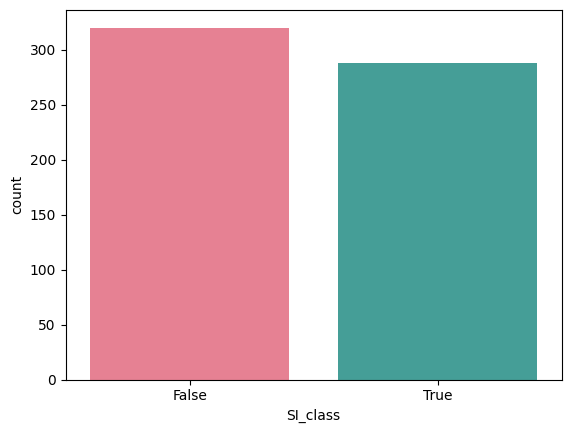

In [14]:
sns.countplot(x ='SI_class', data =  encode_train, hue='SI_class', palette="husl", legend=False)
plt.show()

### **Данные получились довольно сбалансированные, дополнительная балансировка не требуется**

In [15]:
# Выделим X и Y
y_train = encode_train['SI_class']
x_train = encode_train.drop(columns=['SI_class'])

y_test = encode_test['SI_class']
x_test = encode_test.drop(columns=['SI_class'])

### **Стандартизируем отобранные данные**

In [16]:
scaler = StandardScaler()

X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

### **Логистическая регрессия**

In [17]:
# Создаем модель логистической регрессии
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Кросс-валидация на тренировочных данных
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')
print("Точность на каждом из фолдов:\n", cv_scores)
print("Средняя точность на кросс-валидации:", np.mean(cv_scores))

# Обучаем модель 
log_reg.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса

# Оценка качества на тестовых данных
print("\nМетрики на тестовой выборке:")
print("----------------------------------------")

# Основные метрики классификации
print(f"Accuracy (Точность): {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (Точность предсказаний): {precision_score(y_test, y_pred):.4f}")
print(f"Recall (Полнота): {recall_score(y_test, y_pred):.4f}")
print(f"F1-score (F-мера): {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")


Точность на каждом из фолдов:
 [0.52459016 0.50819672 0.59016393 0.63636364 0.63636364]
Средняя точность на кросс-валидации: 0.5791356184798808

Метрики на тестовой выборке:
----------------------------------------
Accuracy (Точность): 0.5830
Precision (Точность предсказаний): 0.5725
Recall (Полнота): 0.5682
F1-score (F-мера): 0.5703
AUC-ROC: 0.6096


#### **Оценка метрик**

**Accuracy** (Точность): 0.583 - Модель правильно предсказывает класс в 58.3% случаев

**Precision** (Точность предсказаний): 0.5725 - Из всех предсказанных положительных классов 57.25% действительно положительные

**Recall** (Полнота): 56.82 - Модель находит 56.82% всех реальных положительных случаев и пропускает 38%

**F1-score** : 0.5703  - баланс между точностью и полнотой, средний результат(чем ближе к 1 тем лучше)

**ROC-AUC** : 0.6096- Модель на 60.96% лучше случайного классификатора

### **Метод ближайших соседей KNN**

In [18]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skopt')

# Параметры для оптимизации
knn_params = {
    'n_neighbors': Integer(3, 100),
    'weights': ['uniform', 'distance'],
    'p': Integer(1, 5)  # 1 - манхэттен, 2 - евклидово
}

# Модель
knn_model = KNeighborsClassifier()

# Оптимизация
knn_search = BayesSearchCV(
    knn_model,
    knn_params,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Обучение
knn_search.fit(X_train, y_train)

# Вывод результатов
print("\nK-Nearest Neighbors")
print("Лучшие гиперпараметры:")
for key, val in knn_search.best_params_.items():
    print(f'{key}: {val}')

# Предсказания
y_pred = knn_search.predict(X_test)
y_proba = knn_search.predict_proba(X_test)[:, 1]

# Метрики
print("\nМетрики на тестовой выборке:")
print("----------------------------------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")



K-Nearest Neighbors
Лучшие гиперпараметры:
n_neighbors: 9
p: 1
weights: uniform

Метрики на тестовой выборке:
----------------------------------------
Accuracy: 0.6273
Precision: 0.6348
Recall: 0.5530
F1-score: 0.5911
AUC-ROC: 0.6591


#### **Оценка метрик**

**Accuracy** (Точность): 0.6273- Модель правильно предсказывает класс в 71% случаев

**Precision** (Точность предсказаний): 0.6348- Из всех предсказанных положительных классов 63,48% действительно положительные

**Recall** (Полнота): 0.5530- Модель находит 55% всех реальных положительных случаев и пропускает 45%

**F1-score** : 0.5911  - баланс между точностью и полнотой, результат значительно улучшился

**ROC-AUC** : 0.6591 - Модель на 65% лучше случайного классификатора уимеет неплохую предсказательную силу

In [24]:
X_train = x_train
X_test = x_test

### **RandomForest**

In [25]:
# Параметры для оптимизации
rf_params = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 20),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.1, 1.0),
    'class_weight': ['balanced', None]  # Для несбалансированных данных
}

# Модель
rf_model = RandomForestClassifier(random_state=42)

# Байесовская оптимизация
rf_search = BayesSearchCV(
    rf_model,
    rf_params,
    n_iter=50,
    cv=5,
    scoring='f1',  
    random_state=42,
    n_jobs=-1
)

# Обучение
rf_search.fit(X_train, y_train)

# Вывод результатов
print("\nRandom Forest Classifier")
print("Лучшие гиперпараметры:")
for key, val in rf_search.best_params_.items():
    print(f'{key}: {val}')

# Предсказания
y_pred = rf_search.predict(X_test)
y_proba = rf_search.predict_proba(X_test)[:, 1]

# Метрики
print("\nМетрики на тестовой выборке:")
print("----------------------------------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")


Random Forest Classifier
Лучшие гиперпараметры:
class_weight: balanced
max_depth: 10
max_features: 0.1359683207862248
min_samples_leaf: 4
min_samples_split: 2
n_estimators: 736

Метрики на тестовой выборке:
----------------------------------------
Accuracy: 0.6162
Precision: 0.6228
Recall: 0.5379
F1-score: 0.5772
AUC-ROC: 0.6579


#### **Оценка метрик**

**Accuracy** (Точность):  0.6162 Модель правильно предсказывает класс в 61% случаев

**Precision** (Точность предсказаний): 0.6228- Из всех предсказанных положительных классов 62% действительно положительные 

**Recall** (Полнота): 0.5379- Модель находит 53% всех реальных положительных случаев и пропускает 47%

**F1-score** : 0.5772  - баланс между точностью и полнотой, результат улучшился

**ROC-AUC** : 0.6579 - Модель на 65% лучше случайного классификатора, имеет неплохую предсказательную силу

Все метрики показали худший результат в сравнении с KNN

### **CatBoost**

In [26]:
# Параметры для оптимизации
cat_params = {
    'iterations': Integer(100, 1000),
    'depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'l2_leaf_reg': Real(1, 10),
    'border_count': Integer(32, 255),
    'bagging_temperature': Real(0, 1)
}

# Модель
cat_model = CatBoostClassifier(
    random_state=42,
    verbose=0,  # Убрать вывод обучения
    auto_class_weights='Balanced'
)

# Оптимизация
cat_search = BayesSearchCV(
    cat_model,
    cat_params,
    n_iter=32,
    cv=3,  # CatBoost медленнее, поэтому меньше фолдов
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Обучение
cat_search.fit(X_train, y_train)

# Вывод результатов
print("\nCatBoost Classifier")
print("Лучшие гиперпараметры:")
for key, val in cat_search.best_params_.items():
    print(f'{key}: {val}')

# Предсказания
y_pred = cat_search.predict(X_test)
y_proba = cat_search.predict_proba(X_test)[:, 1]

# Метрики
print("\nМетрики на тестовой выборке:")
print("----------------------------------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")


CatBoost Classifier
Лучшие гиперпараметры:
bagging_temperature: 0.006772305066787552
border_count: 237
depth: 3
iterations: 100
l2_leaf_reg: 6.9497566280671705
learning_rate: 0.04482436710156541

Метрики на тестовой выборке:
----------------------------------------
Accuracy: 0.5793
Precision: 0.5804
Recall: 0.4924
F1-score: 0.5328
AUC-ROC: 0.6262


#### **Оценка метрик**

**Accuracy** (Точность):  0.5793 Модель правильно предсказывает класс в 72% случаев

**Precision** (Точность предсказаний): 0.5804- Из всех предсказанных положительных классов 70% действительно положительные 

**Recall** (Полнота): 0.4924- Модель находит 82% всех реальных положительных случаев и пропускает 18%

**F1-score** : 0.5328  - баланс между точностью и полнотой, результат улучшился

**ROC-AUC** : 0.6262 - Модель на 62.62% лучше случайного классификатора, имеет неплохую предсказательную силу

### По совокупности метрик лучшая модель **KNN**

#### Соберем полный пайплайн для нашей модели и обучим ее

In [29]:
# Создаем пайплайн
# Создаем пайплайн
mod_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Стандартизируем
    ('KNN', KNeighborsClassifier(
        n_neighbors= 9,
        p= 1
    ))
])

In [30]:
encode_df = preprocessing_pipeline.fit_transform(df_class)
Y = encode_df['SI_class']
X = encode_df.drop(columns=['SI_class'])

mod_pipeline.fit(X, Y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('KNN', KNeighborsClassifier(n_neighbors=9, p=1))])

#### Модель  с лучшими метриками обучена и готова к Production.